# Part A: Classification

|Name|Admin No.|Class|
|----|-----|----|
|Timothy Chia Kai Lun|P2106911|DAAA/FT/2A/02|

### <u>Pediction Task</u>

**How is the prediction task defined?**

Dataset contains data on machines owned by a manufacturing company. </br>
It also includes the status (i.e. normal/fail) as well as other characteristics of each machines. </br>
A machine's operational status is important to a company as having faulty equipment can halt production and risk loss in revenue. </br>

Hence, the task is to create a classication model that predicts machine status based on the machines features.

**What is the meaning of the output variable?**

The output variable, machine status, contains two class labels: 0 or 1. </br>
A status of 0 means the machine is operational and working, where a status of 1 indicates a machine has failed and is not working.

---

### Getting Started

To begin, I will import some relevant libraries which will help me get a better understanding of the data and make some visualization for analysis as well as build a classification model.

## Importing Libraries

In [1248]:
import numpy as np
import pandas as pd 
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt 
from numpy.random import rand

# Model Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_predict, cross_val_score, validation_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

# Preprocessing
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import learning_curve, ShuffleSplit

# Models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

from warnings import filterwarnings 
filterwarnings('ignore')

## Defining Utility Functions

To aid in the analysis, I will make use of several  functions.

In [1249]:
# Fills NaN cells with dummy values
def fill_dummy_values(df, scaling_factor=0.075):
  df_dummy = df.copy(deep=True)

  for col_name in df_dummy:
    col = df_dummy[col_name]
    col_null = col.isnull()    

    # Calculate number of missing values in column 
    num_nulls = col_null.sum()

    # Calculate column range
    col_range = col.max() - col.min()
    
    # Scale the random values to scaling_factor times col_range
    dummy_values = (rand(num_nulls) - 2) * scaling_factor * col_range + col.min()
    col[col_null] = dummy_values

  return df_dummy

# displays performance metrics of multiple models
def score_models(X_train, y_train, model_list, metric_list, cv):
    scores = []

    for name, model in model_list:
        model.fit(X_train, y_train)
        cv_score = cross_validate(model, X_train, y_train, scoring=metric_list, cv=cv, n_jobs=2, return_train_score=True)
        scores.append(pd.Series(cv_score, name=name).apply(np.mean, axis=0))
        temp_df = pd.DataFrame(scores)

    return temp_df

# plots learning curve
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes.set_title(f'Learning Curve ({title})', fontsize=15)
    axes.set_xlabel("Training examples", fontsize=15)
    axes.set_ylabel("Score", fontsize=15)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring='f1')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r")

    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g")

    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    if ylim is not None:
        axes.set(
        ylim=(
            min(np.nanmin(train_scores), np.nanmin(test_scores)) - 0.01,
            max(np.nanmax(train_scores), np.nanmax(test_scores)) + 0.01,
            )
        )
    return plt

def plot_validation_curve(param_name, param_range):
    train_scores, test_scores = validation_curve(
        dtc,
        X_train,
        y_train,
        param_name=param_name,
        param_range=param_range,
        scoring="precision",
        n_jobs=-1,
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with DecisionTreeClassifier")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.semilogx(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )

    plt.semilogx(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )

    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )

    plt.legend(loc="best")
    return plt

## Importing dataset

In [1250]:
factory_df = pd.read_csv('datasets/factory_data (classification).csv', na_values=[''])

## Exploratory Data Analysis
---

In [1251]:
factory_df

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...,...,...
19995,19996,T87335,M,25.75,35.35,NaN,29.5,14,0
19996,19997,Z59525,H,25.85,35.35,1632.0,31.8,17,0
19997,19998,T83921,M,25.95,NaN,NaN,33.4,22,0
19998,19999,K42424,H,25.95,35.65,1408.0,48.5,25,0


In [1252]:
factory_df.shape

(20000, 9)

- The dataset contains 20000 rows and 9 columns

In [1253]:
factory_df.head()

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0


- Taking a look at the first 5 rows of data, majority of columns contain numerical data
- `Quality` column contains categorical (ordinal) data, which may need to be encoded later on.
- `Unique ID` and `Product ID` contain identifiers for each row and each machine. 
    - As these values do not provide any insight to my analysis, it would be best to drop them.

In [1254]:
factory_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unique ID,20000.0,10000.500000,5773.647028,1.00,5000.75,10000.50,15000.25,20000.00
Ambient T (C),20000.0,26.904930,2.000834,22.15,25.25,26.95,28.45,31.45
Process T (C),19600.0,36.904291,1.483647,32.55,35.75,36.95,37.95,40.75
Rotation Speed (rpm),18812.0,1538.795397,178.674963,1168.00,1423.00,1503.00,1613.00,2886.00
Torque (Nm),20000.0,39.986910,9.968684,3.80,33.20,40.10,46.80,76.60
Tool Wear (min),20000.0,107.951000,63.652555,0.00,53.00,108.00,162.00,253.00
Machine Status,20000.0,0.033900,0.180976,0.00,0.00,0.00,0.00,1.00


- `Rotation Speed (rpm)` column contains values of a higher magnitude, which will need to be scaled.
- Of the numerical columns, `Process T (C)` and `Rotation (rpm)` appear to have missing values, suggesting imputation.

In [1255]:
factory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unique ID             20000 non-null  int64  
 1   Product ID            20000 non-null  object 
 2   Quality               19009 non-null  object 
 3   Ambient T (C)         20000 non-null  float64
 4   Process T (C)         19600 non-null  float64
 5   Rotation Speed (rpm)  18812 non-null  float64
 6   Torque (Nm)           20000 non-null  float64
 7   Tool Wear (min)       20000 non-null  int64  
 8   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.4+ MB


- `Quality` column also contains missing values, prompting imputation.
- `Ambient T (C)`, `Process T (C)`, `Rotation Speed (rpm)` and  `Torque (Nm)` are continuous features.
- `Tool Wear (min)` is a discrete feature.
- Looking at each feature, it may be possible to feature engineer new columns.
    - Horsepower: `Torque (Nm)` * `Rotation Speed (rpm)` / 5252

## Univariate Analysis

### Quality Count

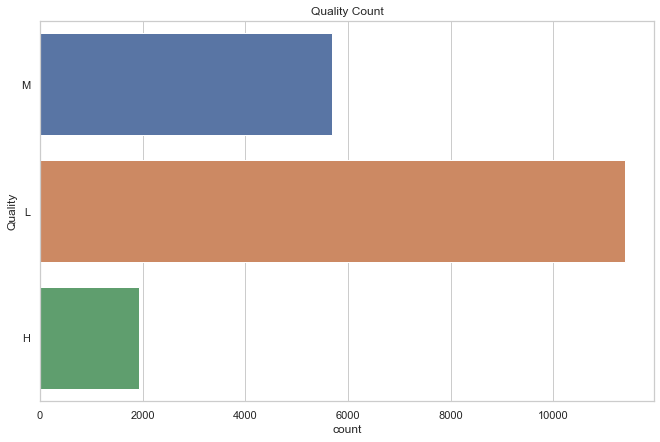

In [1256]:
sns.set(rc={'figure.figsize' : (11, 7)})
sns.set_style('whitegrid')

sns.countplot(y=factory_df['Quality'])
plt.title('Quality Count')
plt.show()

- Majority of machines are of low quality
- Lesser amounts of high quality machines compared to low and medium quality.
- Does quality cause a machine to fail? This may be an important feature for our classication model.

### Ambient Temperature Distribution

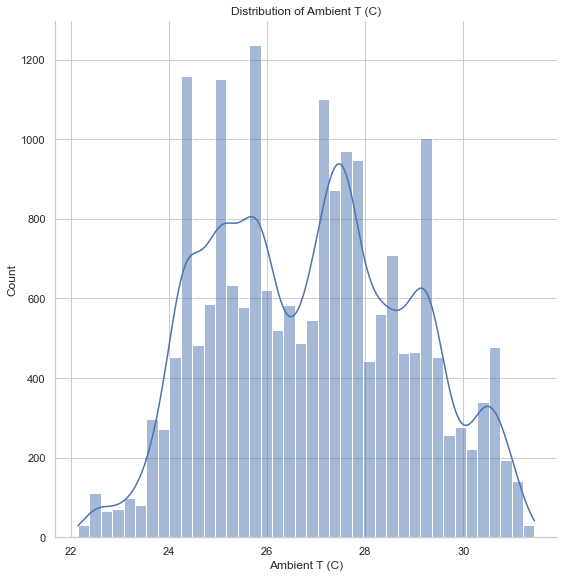

In [1257]:
sns.displot(x='Ambient T (C)', kde=True, height=8, data=factory_df)
plt.title('Distribution of Ambient T (C)')
plt.show()

### Process Temperature Distribution

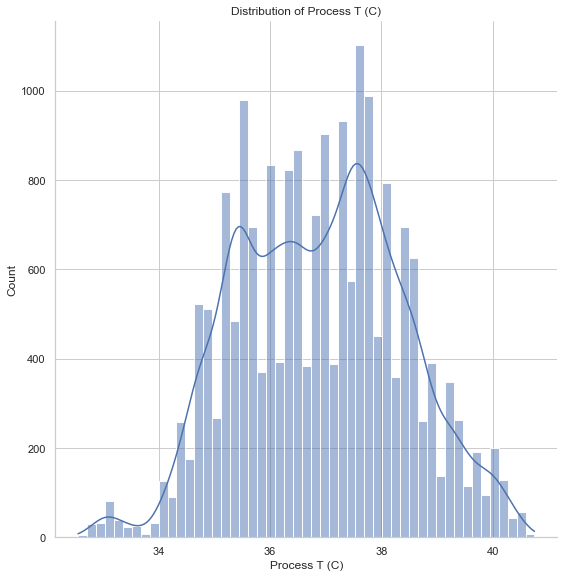

In [1258]:
sns.displot(x='Process T (C)', kde=True, height=8, data=factory_df)
plt.title('Distribution of Process T (C)')
plt.show()

### Rotation Speed Distribution

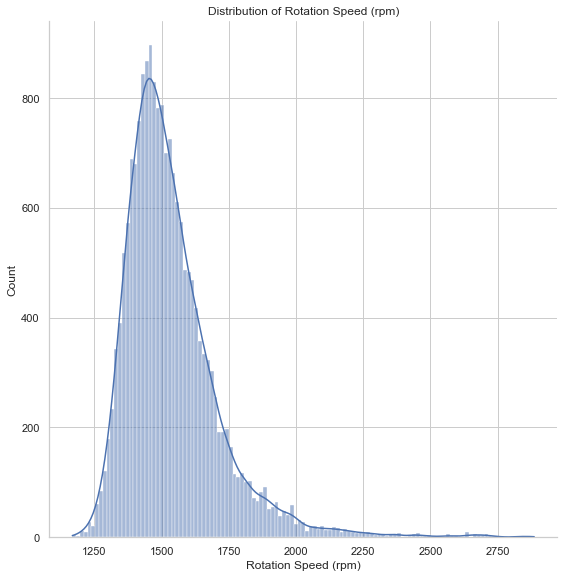

In [1259]:
sns.displot(x='Rotation Speed (rpm)', kde=True, height=8, data=factory_df)
plt.title('Distribution of Rotation Speed (rpm)')
plt.show()

- Distribution of `Rotation Speed (rpm)` is positively skewed with the right tail extending.
- May need to be normalized with log scale or standard scaler.

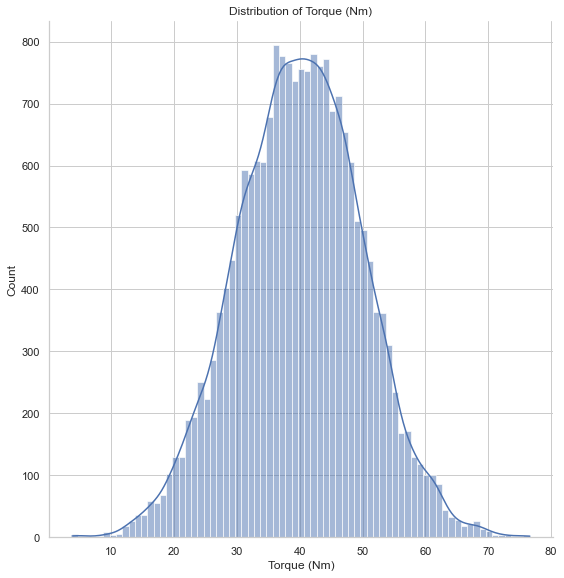

In [1260]:
sns.displot(x='Torque (Nm)', kde=True, height=8, data=factory_df)
plt.title('Distribution of Torque (Nm)')
plt.show()

- Distribution of `Torque (Nm)` displays a normal distribution.

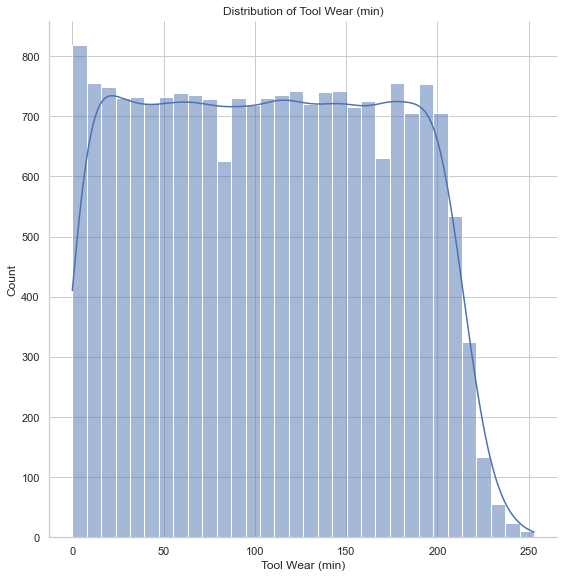

In [1261]:
sns.displot(x='Tool Wear (min)', kde=True, height=8, data=factory_df)
plt.title('Distribution of Tool Wear (min)')
plt.show()

- Distribution of `Tool Wear (min)` displays a somewhat uniform distribution.
- The mode minutes for tool wear appears to be zero, which makes no sense as it would mean the machine never fails. </br> Hence, these values may need to be imputed.

### Machine Status Count

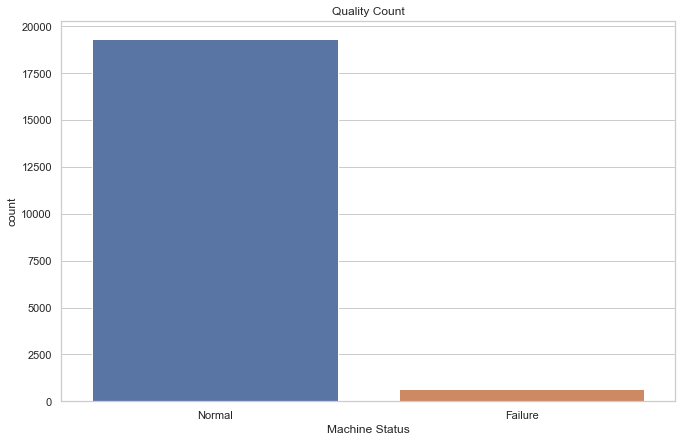

In [1262]:
labels = ['Normal', 'Failure']

ax = sns.countplot(x='Machine Status', data=factory_df)
ax.set_xticklabels(labels=labels)
plt.title('Quality Count')
plt.show()

- Target feature is extremely imbalanced with most machines not failing.
- This might suggest that machine failure is a rare occurence.
- An unbalanced dataset will bias the prediction model towards the majority class. Hence, it will need to be dealth with.
- There two approaches when dealing with imbalanced classes.
    - Oversampling: Takes random samples for the minority class (failure) and duplicates those samples to the length of the majority class (normal).
    - Undersampling: Removes random samples from the majority class (normal) to the length of the minority class (failure).
- Because undersampling will severely reduce the size of the dataset, the better approach would be to use oversampling.

## Bivariate Analysis

### Pearson Correlation
The Pearson coefficient is a type of correlation coefficient that represents the relationship between two variables that are measured on the same interval or ratio scale and is a measure of the strength of the association between two continuous variables.

$$
r =\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}
$$

$r$ = correlation coefficient </br>
$x_{i}$ = values of the x-variable in a sample </br>
$\bar{x}$ = mean of the values of the x-variable </br>
$y_{i}$ = values of the y-variable in a sample </br>
$\bar{y}$ = mean of the values of the y-variable

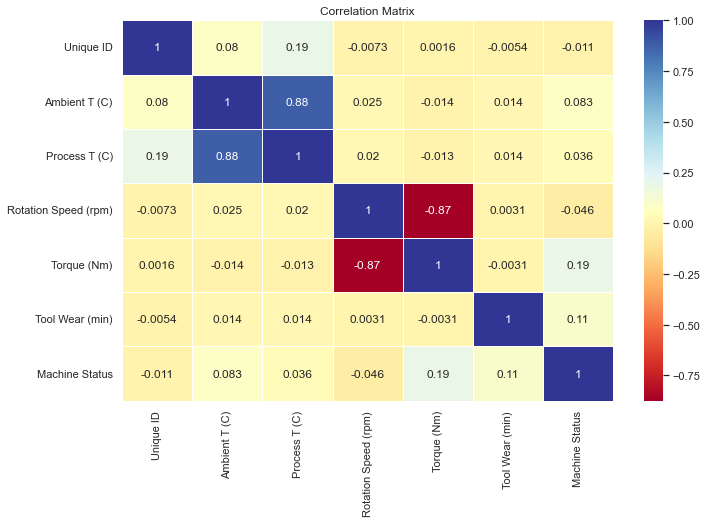

In [1263]:
sns.heatmap(factory_df.corr(), annot=True, linewidths=.5, cmap='RdYlBu')
plt.title('Correlation Matrix')
plt.show()

- `Process T (C)` and `Ambient T (C)` appear to have a strong positive correlation.
- This makes sense as the surrounding temperature would affect a machine's internal temperature.
- `Rotation Speed (rpm)` and `Torque (Nm)` appear to have a strong negative correlation.
- This would imply that the higher the rotational force, the lower the rotation speed of a machine gets.

## Investigating Missing Values

Earlier, it was noticed that the dataset contained missing values in a few columns. I will be analysing the missing data to see </br> if there are correlations between missingness
found in `Quality`, `Process T (C)` and `Rotation Speed (rpm)`.


In [1264]:
missing_percent = factory_df.isna().mean() * 100
missing_count = factory_df.isna().sum()

missing_df = pd.concat({
    "Count": missing_count, 
    "Percent": missing_percent
}, axis=1)

missing_df = missing_df.sort_values(by=['Count', 'Percent'], ascending=False)
missing_df = missing_df[missing_df['Percent'] != 0]
total_percent = sum(missing_df['Percent'])

display(missing_df)
print(f'Total Percentage: {total_percent}')

,Count,Percent
Rotation Speed (rpm),1188,5.940
Quality,991,4.955
Process T (C),400,2.000


Total Percentage: 12.895


- 1188 rows contain missing values for `Rotation Speed (rpm)`.
- 991 rows contain missing values for `Quality`.
- 400 rows contain missing values for `Process T (C)`.
- 12.9% of the entire dataset contains missing values, this amount is significant enough to reject dropping rows with missing values.

### Missingness Matrix

I want to find out if missing values in a feature may be the cause for missingness in the other columns. </br>
Hence, I will use the missingno library's missingness matrix plot to spot correlations/patterns in missing values.

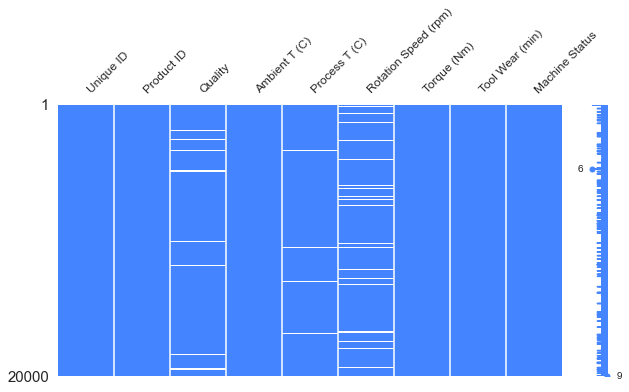

In [1265]:
msno.matrix(factory_df, figsize=(10,5), color=(0.27, 0.52, 1.0), fontsize=12)
plt.show()

- Missingness in `Process T (C)` and `Rotation Speed (rpm)` appear to be missing completely at random, although they do appear to be slighty correlated.
- Further analysis is needed to prove that this is actually the case.
- Missingness in `Quality` appears to have no correlation between missingness in `Process T (C)` and `Rotation Speed (rpm)`, hence it is probably missing completely random.

### Missingness of Process Temp Against Rotation Speed

matplotlib skips all missing values while plotting. Therefore, dummy values will be filled for all missing values in the dataframe before plotting.

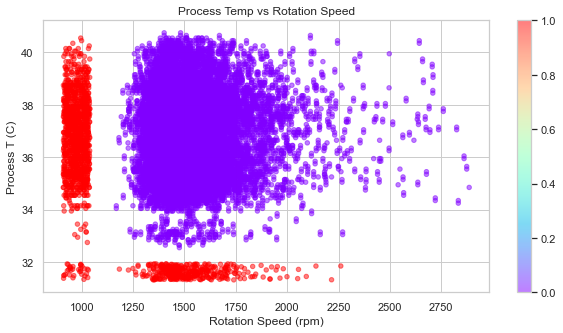

In [1266]:
factory_dummy = fill_dummy_values(factory_df[['Process T (C)', 'Rotation Speed (rpm)']])
nullity = factory_df['Rotation Speed (rpm)'].isnull() + factory_df['Process T (C)'].isnull() 

factory_dummy.plot(x='Rotation Speed (rpm)', y='Process T (C)', kind='scatter', alpha=0.5, c=nullity, cmap='rainbow', sharex=False, figsize=(10, 5))
# ax.legend(['NA', 'Not NA'])
plt.title('Process Temp vs Rotation Speed')
plt.show()

- Red points along <u>y-axis</u> represent the missing values of `Rotation Speed (rpm)` against their `Process T (C)` values.
- Red points along <u>x-axis</u> represent the missing values of `Process T (C)` against thier `Rotation Speed (rpm)` values.
- Red points at the <u>bottom-left corner</u> represent missing values of both `Rotation Speed (rpm)` and `Process T (C)`.
- Missing values of `Rotation Speed (rpm)` are spread throughout `Process T (C)` and vice versa.
    - Hence, no correlation can be observed between the missingness in `Rotation Speed (rpm)` and `Process T (C)`.
- In short, the presence/absence of a `Process T (C)` is not at all correlated with `Rotation Speed (rpm)`. 
    - It can be concluded that the values are missing completely at random (MCAR).

## Data Preprocessing
---

Now that the features and target have been analysed, the next steps would be 
1) Impute missing data
3) Encode categorical features
2) Resample target feature
4) Feature engineer new columns
5) Standardize numerical features

### Seperate Feature and Target Variables

First, I will be splitting the feature and target variables for easier preprocessing.

In [1267]:
X = factory_df.drop(['Unique ID', 'Product ID', 'Machine Status'], axis=1)
y = factory_df['Machine Status']

### Imputation

I will be imputing missing values of `Quality` with its mode

In [1268]:
X_mode = X.copy(deep=True)
X_mode['Quality'].fillna(X_mode['Quality'].mode()[0], inplace=True)

Next, I will replace 0s in `Tool Wear (min)` with its mean

In [1269]:
# replacing 0 mins with mean
X_mode.loc[X_mode['Tool Wear (min)'] == 0, ['Tool Wear (min)']] = X_mode['Tool Wear (min)'].mean()

### Encoding Features

It necessary to perform a ordinal encoding on `Quality` to convert it to numerical data. </br>
I will also be using nearest neighbor imputation on `Process T (C)` and `Rotation Speed (rpm)` as they are numerical. 
</br></br>
Nearest neighbor imputation replaces missing values with values from related cases within the dataset.

In [1270]:
oe = OrdinalEncoder(categories=[['L', 'M', 'H']])
ki = KNNImputer(n_neighbors=5)

transformers = [('Ordinal', oe, ['Quality']),
                ('KNN Imputer', ki, ['Process T (C)', 'Rotation Speed (rpm)'])]

ct = ColumnTransformer(transformers, remainder='passthrough')

col_names = ['Quality', 'Process T (C)', 'Rotation Speed (rpm)', 'Ambient T (C)', 'Torque (Nm)', 'Tool Wear (min)']

X_imputed = pd.DataFrame(ct.fit_transform(X_mode), columns=col_names)

X_imputed.tail(10)

,Quality,Process T (C),Rotation Speed (rpm),Ambient T (C),Torque (Nm),Tool Wear (min)
19990,0.0,35.450000,1527.000000,25.75,36.2,3.0
19991,1.0,35.350000,1485.600000,25.85,26.1,5.0
19992,0.0,35.350000,1484.000000,25.75,39.2,8.0
19993,0.0,35.350000,1401.000000,25.75,47.3,10.0
19994,0.0,35.250000,1634.000000,25.75,27.9,12.0
19995,1.0,35.350000,1485.600000,25.75,29.5,14.0
19996,2.0,35.350000,1632.000000,25.85,31.8,17.0
19997,1.0,36.904291,1538.795397,25.95,33.4,22.0
19998,2.0,35.650000,1408.000000,25.95,48.5,25.0
19999,1.0,35.650000,1500.000000,25.95,40.2,30.0


- After encoding, `Quality` contains values: 0, 1, and 2 which map to L, M, and H respectively.
- `Process T (C)` and `Rotation Speed (rpm)`'s missing values have also been imputed with values from related records.

### Train-Test Split
To evaluate the final chosen models, a small independent test set will be made to report on the final performance of each classifiers. </br>
When creating the hold out set, stratifying the split ensures that the distribution of classes is the same in both the test set and the training set. </br>
The split ratio will be 80:20. </br></br>

I am splitting the dataset before oversampling to prevent data leakage. </br>

In [1271]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, stratify=y, shuffle=True, test_size=.2, random_state=24)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16000, 6) (16000,)
(4000, 6) (4000,)


### Oversampling - Machine Status

Oversampling will be done only to the train set the prevent the duplicate records from being in the test set upon splitting. 

In [1272]:
ros = RandomOverSampler(random_state=34)
X_res, y_res = ros.fit_resample(X_train, y_train)

print(X_res.shape, y_res.shape)

(30916, 6) (30916,)


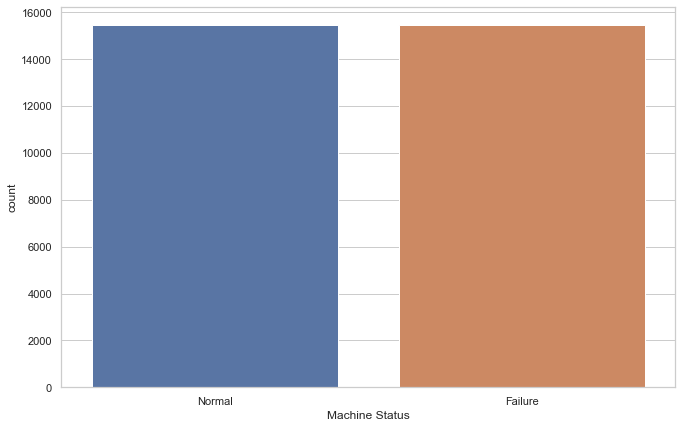

In [1273]:
labels = ['Normal', 'Failure']

ax = sns.countplot(y_res)
ax.set_xticklabels(labels=labels)
# plt.title('Quality Count')
plt.show()

- After oversampling, our target class is now balanced and any bias due to the unbalanced class should have been eliminated.


### Feature Creation

Horsepower is often used as a measure of engine power and other mechanical devices. Hence, for this prediction task, it is relevant to include such a metric.

Horsepower can be calculated with:

$$
hp =\frac{t * rpm}{5252}
$$

$hp$ = Horse power </br>
$t$ = Torque in pound-feet </br>
$rpm$ = Rotation speed</br>

In [1274]:
# To convert newton-meters (Nm) to foot-pounds (ft/lbs) all you need to do is divide your figure (Nm) by 1.356
X_res['Horsepower'] = ((X_res['Torque (Nm)'] / 1.356) * X_res['Rotation Speed (rpm)']) / 5252
X_test['Horsepower'] = ((X_test['Torque (Nm)'] / 1.356) * X_test['Rotation Speed (rpm)']) / 5252

In [1275]:
X_res.describe()

,Quality,Process T (C),Rotation Speed (rpm),Ambient T (C),Torque (Nm),Tool Wear (min),Horsepower
count,30916.000000,30916.000000,30916.000000,30916.000000,30916.000000,30916.000000,30916.000000
mean,0.412343,37.042004,1520.825109,27.336784,44.967176,126.324443,9.119917
std,0.632339,1.416401,291.894331,2.082212,14.478684,69.255604,2.211710
min,0.000000,32.650000,1168.000000,22.150000,3.800000,2.000000,0.901749
25%,0.000000,35.950000,1361.000000,25.550000,35.900000,66.000000,7.843135
50%,0.000000,37.150000,1440.000000,27.550000,46.300000,128.000000,9.161168
75%,1.000000,37.950000,1568.000000,29.150000,54.900000,192.000000,10.573637
max,2.000000,40.750000,2886.000000,31.350000,76.600000,253.000000,15.710239


In [1276]:
X_train = X_res
y_train = y_res

## Model Selection

---

For model selection, I will train some models and deem the best model based on metrics and explainability.

### Evaluation Methodology
I will use k-Fold Cross Validation to select candidate models from the training set. </br>The final model will then be evaluated on the test set.

### Scoring Metrics
As the prediction task is a classification problem, I will use the confusion matrix and related metrics to view performance of candidate models.

![](https://i.imgur.com/6lp9HNy.jpg)

I will mainly focus on the precision metric as I want to minimize the amount false positives. </br>
Formula for Precision is as follows:
$
Precision = \frac{TP}{TP + FP}
$

Cross Validation will be done across 5 folds.

In [1277]:
scoring_metrics = ['precision', 'recall', 'f1', 'roc_auc']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

I will instantiate various models with default hyperparameters and pick a candidate model from there.

In [1278]:
scoring_metrics = ['precision', 'recall', 'f1', 'roc_auc']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

models = [
    ("KNN", KNeighborsClassifier()), 
    ("LogReg", LogisticRegression()), 
    ("DecisionTree", DecisionTreeClassifier()), 
    ("RandomForest", RandomForestClassifier()), 
    ("GradientBoost", GradientBoostingClassifier()),
    ('Ridge', RidgeClassifier()),
    ('SGD', SGDClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('GaussianNB', GaussianNB()),
    ('Extra Trees', ExtraTreesClassifier())
]

score_df = score_models(X_train, y_train, models, scoring_metrics, cv)

In [1279]:
score_df.sort_values(by=['test_precision', 'train_precision', 'test_f1', 'train_f1'], ascending=False).style.apply(
    lambda x: ["background-color: green; color: white" if v else "" for v in x == x.max()]
).apply(
    lambda x: [
        "background-color: red; color: white" if v else "" for v in x == x.min()
    ]
)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
Extra Trees,0.788344,0.171779,0.999225,1.000000,1.000000,1.000000,0.999612,1.000000,1.000000,1.000000
RandomForest,1.422596,0.135656,0.997874,1.000000,1.000000,1.000000,0.998936,1.000000,1.000000,1.000000
DecisionTree,0.055656,0.010092,0.992627,1.000000,1.000000,1.000000,0.996300,1.000000,0.996275,1.000000
KNN,0.051843,0.159200,0.963407,0.975014,1.000000,1.000000,0.981360,0.987349,0.996180,1.000000
GradientBoost,2.252303,0.026016,0.942491,0.949276,0.972907,0.974552,0.957447,0.961747,0.992468,0.993810
AdaBoost,0.639823,0.062308,0.925340,0.929404,0.936483,0.936711,0.930859,0.933040,0.977609,0.979481
Ridge,0.009504,0.010591,0.856126,0.856625,0.829245,0.832148,0.842441,0.844207,0.917124,0.919880
GaussianNB,0.008123,0.009098,0.840954,0.844121,0.769069,0.765187,0.803380,0.802716,0.897021,0.899900
LogReg,0.162527,0.009979,0.833583,0.836863,0.851086,0.854587,0.842187,0.845623,0.907557,0.909662
SGD,0.385557,0.009579,0.732942,0.737424,0.861618,0.862434,0.773019,0.775705,0.891344,0.893988


Most models performs equally well with >90% mean cross-validation precision score of 5 folds, highlighted in green.

**How did you select which leraning algorithm to use?** </br>

There is a dilemma in choosing models as almost all models tested have mean cross validation scores of >90%. </br>
I will be choosing DecisionTreeClassifier as it is the simplest model with the best explainability

### Creating Baseline Model

Before building the classification model, I will use the Dummy Classifier as a baseline to compare all other models against. </br>
It is a classifier model that makes predictions without trying to find patterns in the data. </br>
This model essentially looks at what label is most frequent in the training set and makes predictions based on that label.

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
Dummy,0.004845,0.01441,0.198642,0.20034,0.4,0.4,0.265456,0.266968,0.5,0.5


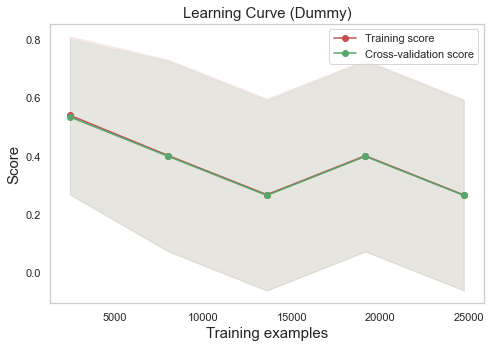

In [1280]:
dummy_score = score_models(X_train, y_train, [("Dummy", DummyClassifier())], scoring_metrics, cv)
display(dummy_score)

fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plot_learning_curve(DummyClassifier(), 'Dummy', X_train, y_train, axes=axes, cv=cv, n_jobs=-1)
plt.tight_layout()
plt.show() 

- The baseline model has quite low precision and precision scores, indicating it is underfitting.

### Decision Tree Model with Default Hyperparameters

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
DecisionTree,0.058191,0.012294,0.993008,1.0,1.0,1.0,0.996492,1.0,0.99647,1.0


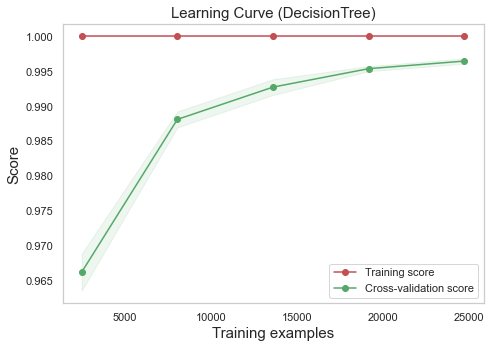

In [1281]:
dt_score = score_models(X_train, y_train, [("DecisionTree", DecisionTreeClassifier())], scoring_metrics, cv)
display(dt_score)

fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plot_learning_curve(DecisionTreeClassifier(), "DecisionTree", X_train, y_train, axes=axes, cv=cv, n_jobs=-1)
plt.tight_layout()
plt.show() 

- The decision tree model performs well on the data as shown by the close gap between the training and validation folds.
- The model appears to have low bias and low variance, making it a good candidate for our final model.

In [1282]:
steps = [('Scaler', StandardScaler(), ['Rotation Speed (rpm)'])]
preprocessor = ColumnTransformer(steps, remainder='passthrough')

### Comparing Baseline and Decision Tree Models

In [1283]:
dummy = make_pipeline(preprocessor, DummyClassifier())
dtc = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=23))

chosen_models = [
    ('Dummy', dummy),
    ('DecisionTree', dtc)
]

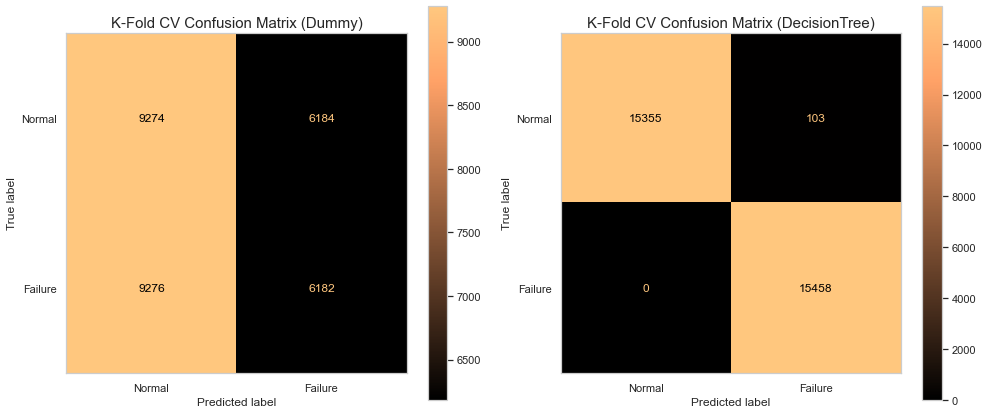

In [1284]:
labels = ['Normal', 'Failure']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (name, model) in enumerate(chosen_models):
    model.fit(X_train, y_train)
    pred = cross_val_predict(model, X_train, y_train)
    cm = confusion_matrix(y_train, pred) 

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=axes[idx], cmap='copper')

    axes[idx].grid(False)
    axes[idx].set_title(f'K-Fold CV Confusion Matrix ({name})', fontsize=15)

plt.tight_layout()
plt.show()

- DecisionTreeClassifier is performing well with k-fold cross validation, with little false predictions we can see the predictions made by the baseline almost seem random.


## Hyperparameter Tuning

**Did you try to tune the hyperparameters of the learning algorithm, and in that case how?**

I use GridSearchCV to iterate through different values of each parameter to get a model with the best precision scores.

Before tuning I will need to know the hyperparameters available for DecisionTreeClassifier. </br>

In [1285]:
for param in list(dtc.get_params().keys())[16:]:
    print(param)

decisiontreeclassifier__ccp_alpha
decisiontreeclassifier__class_weight
decisiontreeclassifier__criterion
decisiontreeclassifier__max_depth
decisiontreeclassifier__max_features
decisiontreeclassifier__max_leaf_nodes
decisiontreeclassifier__min_impurity_decrease
decisiontreeclassifier__min_samples_leaf
decisiontreeclassifier__min_samples_split
decisiontreeclassifier__min_weight_fraction_leaf
decisiontreeclassifier__random_state
decisiontreeclassifier__splitter


In [1286]:
params = {
    'decisiontreeclassifier__criterion' : ['gini', 'entropy', 'log_loss'],
    'decisiontreeclassifier__max_depth' :  np.arange(1, 25),
    'decisiontreeclassifier__max_leaf_nodes' : np.arange(1, 25)
}

dtc_cv = GridSearchCV(dtc, param_grid=params, n_jobs=-1, scoring='recall')
dtc_cv.fit(X_train, y_train)

criterion = dtc_cv.best_params_['decisiontreeclassifier__criterion']
max_depth = dtc_cv.best_params_['decisiontreeclassifier__max_depth']
max_leafs = dtc_cv.best_params_['decisiontreeclassifier__max_leaf_nodes']

for param in dtc_cv.best_params_:
    print(f'{param}: {dtc_cv.best_params_[param]}')

print(dtc_cv.best_score_)

decisiontreeclassifier__criterion: entropy
decisiontreeclassifier__max_depth: 12
decisiontreeclassifier__max_leaf_nodes: 45
0.9941131934594573


### Decision Tree with Tuned Hyperparameters

I will now instantiate a decision tree model based on the best parameter values after tuning.

In [1287]:
dtc_tuned = make_pipeline(preprocessor, DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_feats, max_leaf_nodes=max_leafs))
dtc_tuned.fit(X_train, y_train)

pred = dtc_tuned.predict(X_test)
cv_score = cross_val_score(dtc_tuned, X_train, y_train, cv=cv, scoring='precision')

print(classification_report(y_test, pred, digits=3))
print(np.mean(cv_score))

              precision    recall  f1-score   support

           0      0.998     0.913     0.954      3864
           1      0.276     0.941     0.427       136

    accuracy                          0.914      4000
   macro avg      0.637     0.927     0.690      4000
weighted avg      0.973     0.914     0.936      4000

0.9122759408996067


### Validation Curves

Validation curves help visualize the performance over a range of values for each hyperparameter.

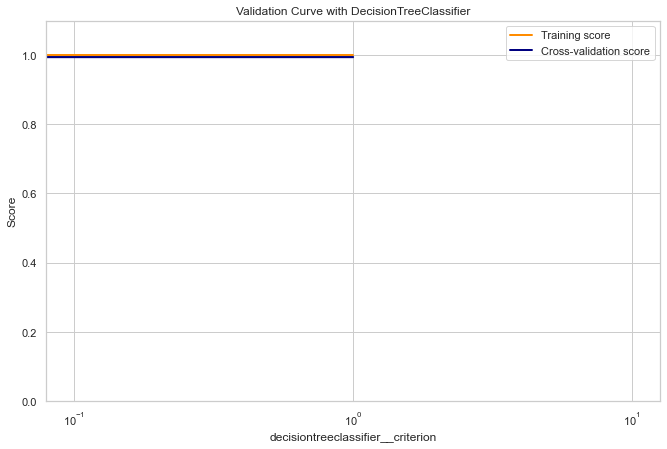

In [1288]:
plot_validation_curve('decisiontreeclassifier__criterion', ['gini', 'entropy', 'log_loss'])
plt.show()

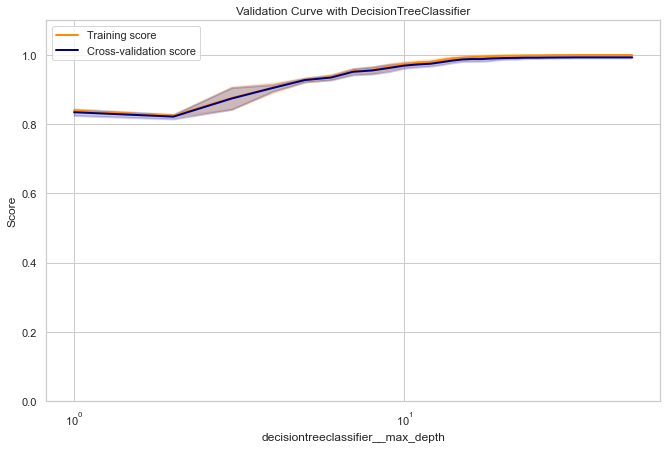

In [1289]:
plot_validation_curve('decisiontreeclassifier__max_depth', np.arange(1, 50))
plt.show()

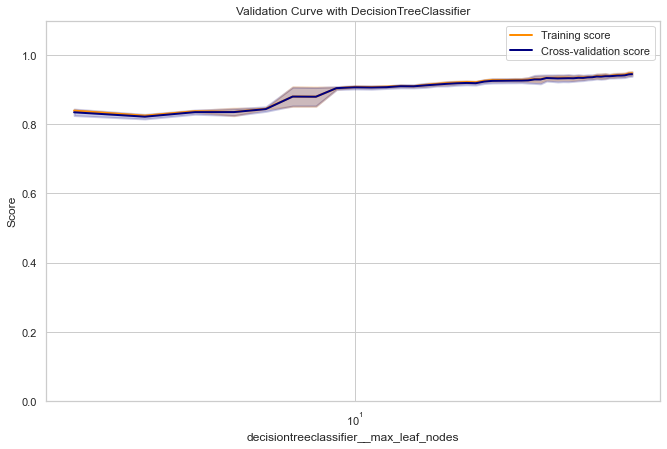

In [1290]:
plot_validation_curve('decisiontreeclassifier__max_leaf_nodes', np.arange(1, 50))
plt.show()

In [1291]:
# plot_validation_curve('decisiontreeclassifier__max_features', np.arange(1, 10))
# plt.show()

- Each parameter reaches it's maximum accuracy and stays consistent after the fact, which proves the hyperparameter values are valid.

## Final Model

Now I will evaluate the decision tree model on unseen data aka the test set.

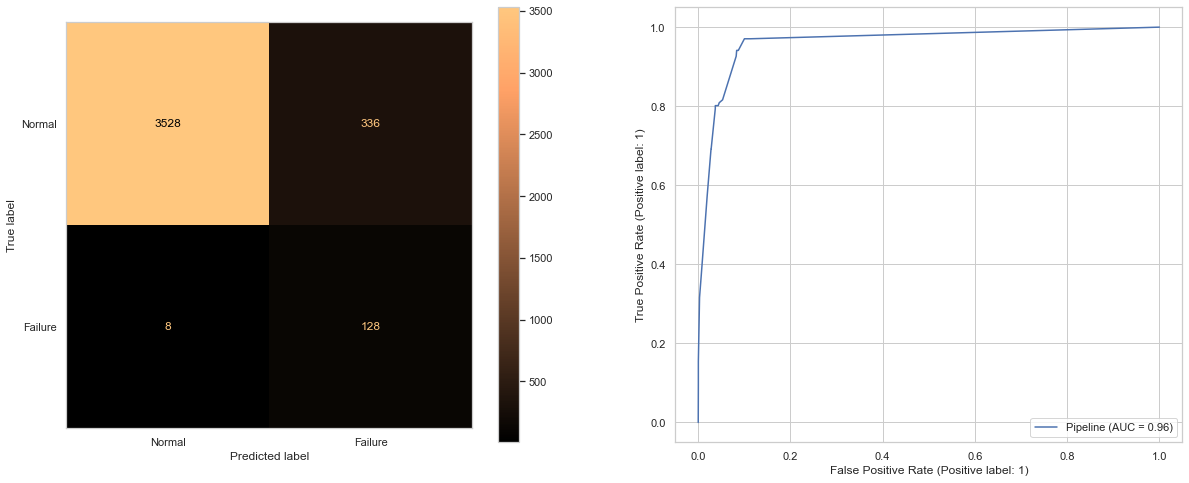

In [1292]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

pred = dtc_tuned.predict(X_test)
cm = confusion_matrix(y_test, pred) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=axes[0], cmap='copper')

RocCurveDisplay.from_estimator(dtc_tuned, X_test, y_test, ax=axes[1])

axes[0].grid(b=None)
plt.show()

### Feature Importance

,Feature Importance
Horsepower,0.271790
Quality,0.218858
Ambient T (C),0.185824
Tool Wear (min),0.161769
Torque (Nm),0.137255
Rotation Speed (rpm),0.016047
Process T (C),0.008458


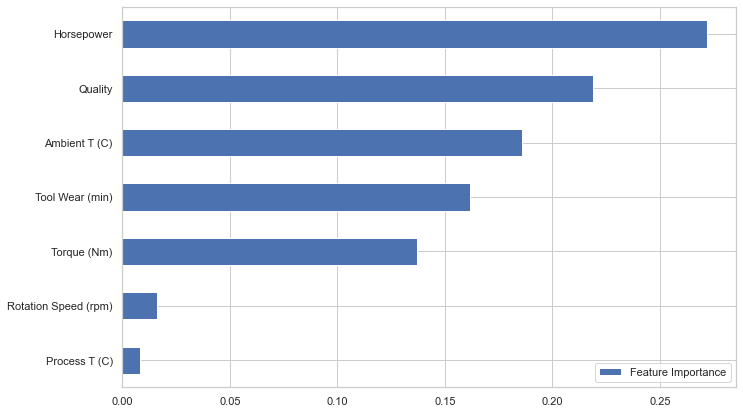

In [1293]:
feat_impt = pd.DataFrame(dtc_tuned[-1].feature_importances_, index=X_train.columns, columns=["Feature Importance"]).sort_values("Feature Importance")
feat_impt.plot(kind='barh')

display(feat_impt.sort_values('Feature Importance', ascending=False))
plt.show()

- It seems that the decision tree model values `Horsepower` the most compared to other features.
- `Process T (C)` appears to be the least important to the model.

## Export Model

In [1300]:
import pickle
os.makedirs('./assets/models', exist_ok=True)
with open('./assets/models/machine_model.pkl', 'wb') as file:
    pickle.dump(dtc_tuned, file)